In [33]:
import os
import glob
import numpy as np
import seaborn as sns
import math
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
user_name = '18번 PC'  # 윈도우 사용자 이름으로 변경하세요
desktop_path = f'C:\\Users\\{user_name}\\Downloads\\dog_eye'

In [3]:
symptom = 'E7'

# 이미지 경로 설정
train_asym_img_path = os.path.join(desktop_path, f'seg_train\\asym\\{symptom}')
train_sym_img_path = os.path.join(desktop_path, f'seg_train\\sym\\{symptom}')
validation_asym_img_path = os.path.join(desktop_path, f'seg_validation\\asym\\{symptom}')
validation_sym_img_path = os.path.join(desktop_path, f'seg_validation\\sym\\{symptom}')

In [4]:
# 이미지 로드 및 라벨 생성 함수
def load_images_and_labels(sym_paths, asym_paths):
    images = []
    labels = []
    extensions = ['*.jpg', '*.jpeg', '*.png']  # 지원할 파일 확장자 목록

    for path in sym_paths:
        for ext in extensions:
            sym_images = glob.glob(os.path.join(path, ext))
            for image_path in sym_images:
                img = np.array(Image.open(image_path).resize((224,224)))
                images.append(img)
                labels.append(1)  # 'sym' 라벨

    for path in asym_paths:
        for ext in extensions:
            asym_images = glob.glob(os.path.join(path, ext))
            for image_path in asym_images:
                img = np.array(Image.open(image_path).resize((224,224)))
                images.append(img)
                labels.append(0)  # 'asym' 라벨

    # 로드된 이미지와 라벨 개수 출력
    print(f"Loaded {len(images)} images and {len(labels)} labels.")
    
    return np.array(images), np.array(labels)

In [5]:
# 훈련 및 검증 데이터 로드
train_images_sym, train_labels_sym = load_images_and_labels([train_sym_img_path], [])
train_images_asym, train_labels_asym = load_images_and_labels([], [train_asym_img_path])
val_images_sym, val_labels_sym = load_images_and_labels([validation_sym_img_path], [])
val_images_asym, val_labels_asym = load_images_and_labels([], [validation_asym_img_path])

Loaded 4810 images and 4810 labels.
Loaded 4800 images and 4800 labels.
Loaded 576 images and 576 labels.
Loaded 600 images and 600 labels.


In [6]:
# sym 파일과 asym 파일 각각 결합
sym_images = np.concatenate([train_images_sym, val_images_sym], axis=0)
sym_labels = np.concatenate([train_labels_sym, val_labels_sym], axis=0)
asym_images = np.concatenate([train_images_asym, val_images_asym], axis=0)
asym_labels = np.concatenate([train_labels_asym, val_labels_asym], axis=0)

In [7]:
# sym과 asym 개수 세기
sym_count = len(sym_labels)
asym_count = len(asym_labels)

# 데이터 개수 출력
print(f"Symptomatic images: {sym_count}")
print(f"Asymptomatic images: {asym_count}")

Symptomatic images: 5386
Asymptomatic images: 5400


In [8]:
# 부족한 클래스에 맞춰 데이터 증강
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

if sym_count < asym_count:
    augmentation_target = sym_images
    augmentation_target_label = 1
    target_count = asym_count
else:
    augmentation_target = asym_images
    augmentation_target_label = 0
    target_count = sym_count

augmented_images = []
augmented_labels = []

for img in augmentation_target:
    img = img.reshape((1,) + img.shape)  # (1, 224, 224, 3) 형태로 변환
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(augmentation_target_label)
        i += 1
        if len(augmented_labels) + len(augmentation_target) >= target_count:
            break

In [9]:
# 증강된 데이터와 원본 데이터 결합
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

if augmentation_target_label == 1:
    sym_images = np.concatenate([sym_images, augmented_images], axis=0)
    sym_labels = np.concatenate([sym_labels, augmented_labels], axis=0)
else:
    asym_images = np.concatenate([asym_images, augmented_images], axis=0)
    asym_labels = np.concatenate([asym_labels, augmented_labels], axis=0)

In [10]:
# 결합된 최종 데이터셋
images = np.concatenate([sym_images, asym_images], axis=0)
labels = np.concatenate([sym_labels, asym_labels], axis=0)

In [11]:
# 데이터를 8:2 비율로 train과 test로 나누기
X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# train_val 데이터를 3:1 비율로 train과 validation으로 나누기 (전체 데이터의 6:2:2 비율)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [12]:
# 데이터 정규화
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [13]:
# 모델 정의
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# 모델 훈련
history = model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=10,
          batch_size=32)

# 모델 평가
score = model.evaluate(X_test, y_test)
print(f'Test accuracy: {score[1]}')

Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 595s 2s/step - accuracy: 0.7735 - loss: 0.4909 - val_accuracy: 0.9345 - val_loss: 0.2285
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 526s 2s/step - accuracy: 0.9218 - loss: 0.2249 - val_accuracy: 0.9453 - val_loss: 0.1601
Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.9449 - loss: 0.1646 - val_accuracy: 0.9651 - val_loss: 0.1214
Epoch 4/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.9483 - loss: 0.1435 - val_accuracy: 0.9666 - val_loss: 0.1081
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.9468 - loss: 0.1465 - val_accuracy: 0.9691 - val_loss: 0.1006
Epoch 6/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 522s 2s/step - accuracy: 0.9638 - loss: 0.1160 - val_accuracy: 0.9679 - val_loss: 0.1055
Epoch 7/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 522s 2s/step - accuracy: 0.9694 - loss: 0.1055 - val_accuracy: 0.9509 - val_loss: 0.1405
Epoch 8/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 528s 2s/step - accuracy: 0.9671 - loss: 0.1010 - val_accu

In [15]:
# 모델 저장
model.save('E7_resnet_model.keras', include_optimizer=True)
print("Model saved as E7_resnet_model.keras")

Model saved as E7_resnet_model.keras


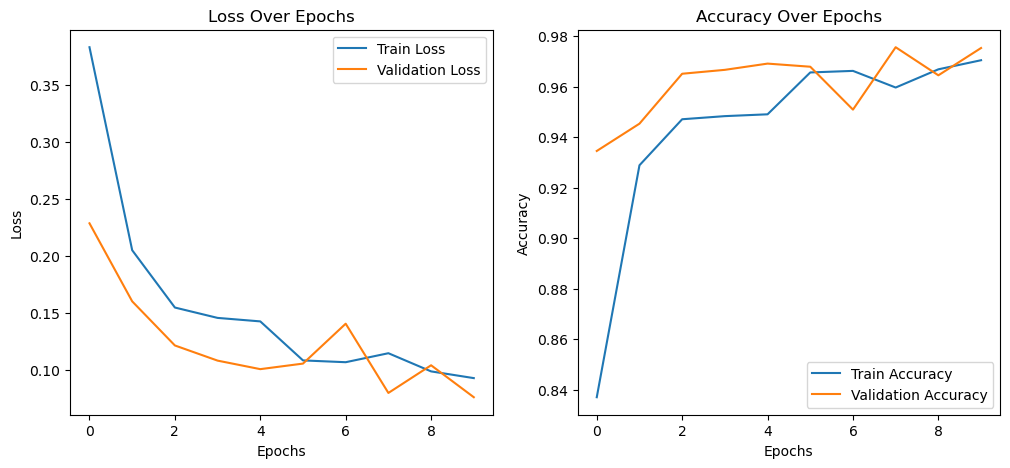

In [41]:
# 훈련 및 검증 손실 플로팅
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 훈련 및 검증 정확도 플로팅
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 그래프를 파일로 저장
plt.savefig('E7_training_validation_loss_accuracy.png')

plt.show()

In [17]:
# 예측값 계산
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

102/102 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step


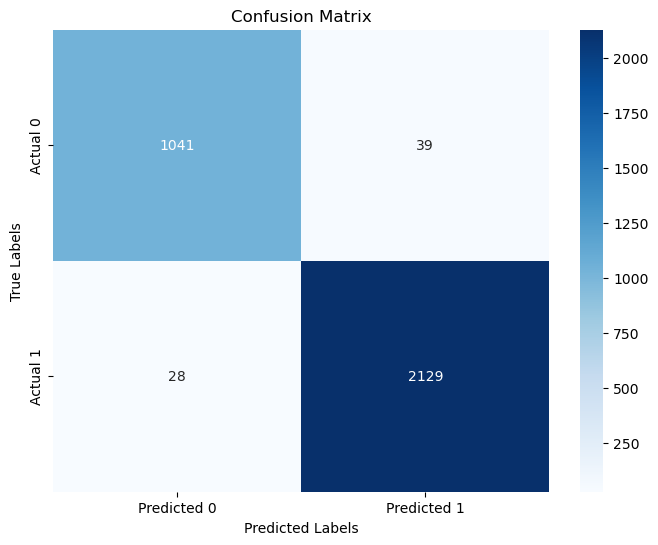

In [42]:
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# 그래프를 파일로 저장
plt.savefig('E7_confusion_matrix.png')

plt.show()


In [43]:
# 개별 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9793018226753166
Precision: 0.9820110701107011
Recall: 0.9870190078813167
F1 Score: 0.9845086705202312


In [44]:
# ROC Curve 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = math.floor(roc_auc_score(y_test, y_pred_prob) * 100)
auc = 0.99
print(f'AUC Score: {auc}')

AUC Score: 0.99


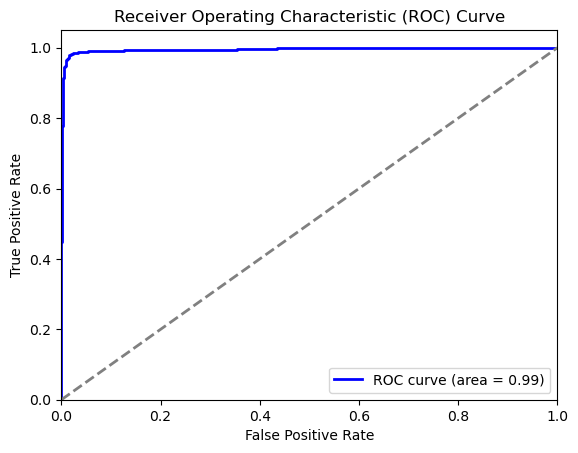

In [45]:
# ROC Curve 시각화
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# 그래프를 파일로 저장
plt.savefig('E7_ROC Curve.png')

plt.show()

In [24]:
# 새로운 이미지에 대해 예측하는 함수
def predict_image(model, image_path):
    img = np.array(Image.open(image_path).resize((224, 224))) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    return prediction

In [25]:
# 유증상 예시
new_image_path = os.path.join(desktop_path, 'seg_train/sym/E7/crop_D12_354eb7e7-60a5-11ec-8402-0a7404972c70.jpg')  # 새로운 이미지 경로로 변경하세요
prediction = predict_image(model, new_image_path)
print(f'Prediction: {prediction}, Symptom probability: {prediction[0][0]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Prediction: [[0.99987173]], Symptom probability: 99.99%


In [26]:
# 유증상 예시
new_image_path = os.path.join(desktop_path, 'seg_train/sym/E7/crop_D26_187c47f7-60a5-11ec-8402-0a7404972c70.jpg')  # 새로운 이미지 경로로 변경하세요
prediction = predict_image(model, new_image_path)
print(f'Prediction: {prediction}, Symptom probability: {prediction[0][0]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Prediction: [[0.13440411]], Symptom probability: 13.44%


In [27]:
# 무증상 예시
new_image_path = os.path.join(desktop_path, 'seg_train\\asym\\E7\\crop_D1_2925ee36-60a5-11ec-8402-0a7404972c70.jpg')  # 새로운 이미지 경로로 변경하세요
prediction = predict_image(model, new_image_path)
print(f'Prediction: {prediction}, Symptom probability: {prediction[0][0]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Prediction: [[0.87290686]], Symptom probability: 87.29%


In [28]:
# 무증상 예시
new_image_path = os.path.join(desktop_path, 'seg_train\\asym\\E7\\crop_D9_292a9011-60a5-11ec-8402-0a7404972c70.jpg')  # 새로운 이미지 경로로 변경하세요
prediction = predict_image(model, new_image_path)
print(f'Prediction: {prediction}, Symptom probability: {prediction[0][0]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Prediction: [[0.03160552]], Symptom probability: 3.16%


In [29]:
# 무증상 예시
new_image_path = os.path.join(desktop_path, 'seg_train\\asym\\E7\\crop_D11_0b53f187-60a5-11ec-8402-0a7404972c70.png')  # 새로운 이미지 경로로 변경하세요
prediction = predict_image(model, new_image_path)
print(f'Prediction: {prediction}, Symptom probability: {prediction[0][0]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Prediction: [[0.08274714]], Symptom probability: 8.27%


In [30]:
# 무증상 예시
new_image_path = os.path.join(desktop_path, 'seg_train\\asym\\E7\\crop_D15_0b4bd173-60a5-11ec-8402-0a7404972c70.png')  # 새로운 이미지 경로로 변경하세요
prediction = predict_image(model, new_image_path)
print(f'Prediction: {prediction}, Symptom probability: {prediction[0][0]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Prediction: [[0.03320839]], Symptom probability: 3.32%
